#### Dataset 
NYC Electricity consumption from 2012 to 2017.demand	precip	temp : Units ?\
No trend, seasonality present. Stationary.\
Source: Unknown

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Datasets/nyc_energy_consumption.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeStamp  49205 non-null  object 
 1   demand     49124 non-null  float64
 2   precip     48975 non-null  float64
 3   temp       49019 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [5]:
data.describe()

demand        precip          temp
count  49124.000000  48975.000000  49019.000000
mean    6067.447361      0.003522     55.520428
std     1285.607657      0.022841     17.704848
min     2859.600000      0.000000      0.330000
25%     5133.862250      0.000000     41.415000
50%     6020.071000      0.000000     56.260000
75%     6684.300000      0.000000     70.540000
max    11456.000000      0.905100     97.260000

In [6]:
data['timeStamp'] = data['timeStamp'].apply(pd.to_datetime)

In [7]:
data.set_index('timeStamp', inplace = True)

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

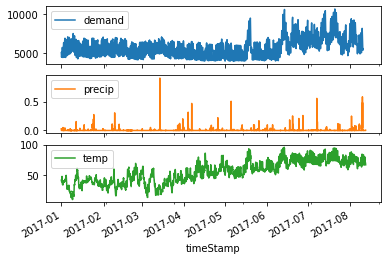

In [8]:
# plots for every data point - Hour
# resample for frequency 'day' with mean

data.loc[data.index.year ==2017].plot(subplots=True)

array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

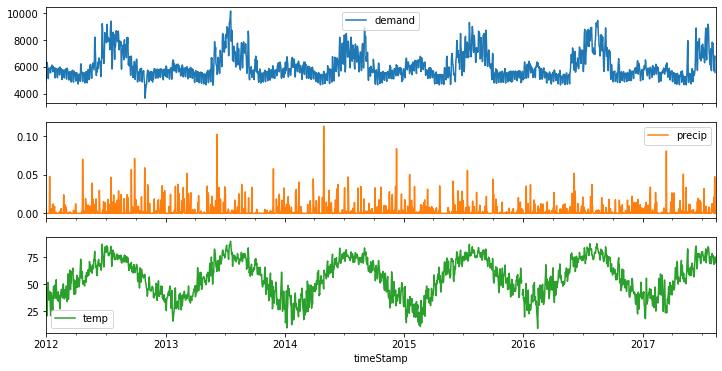

In [9]:
# resample by taking the mean reading of the day
data.resample('D').mean().plot(subplots=True, figsize=(12,6))

#### Univariate Modelling - FBProphet
Additive modelling technique.
decomposable  time  series  model  with  three  main model components:  trend, seasonality, and holidays.  They are combined as following: $$y(t) =g(t) +s(t) +h(t) +\epsilon{(t)}$$
paper: https://peerj.com/preprints/3190/

In [10]:
data_daily = data.resample('D').mean()

In [11]:
from fbprophet import Prophet

In [12]:
# prophet has a format the timestamp/datetime index needs to be called ds and the series is y. 
nyc_daily_demand = data_daily.reset_index()[['timeStamp', 'demand']].rename({'timeStamp': 'ds', 'demand': 'y'}, axis = 1)

In [13]:
# prophet can handle missing values
nyc_daily_demand

ds            y
0    2012-01-01  4954.833333
1    2012-01-02  5302.954167
2    2012-01-03  6095.512500
3    2012-01-04  6336.266667
4    2012-01-05  6130.245833
...         ...          ...
2046 2017-08-08  6471.626042
2047 2017-08-09  6811.112167
2048 2017-08-10  5582.297000
2049 2017-08-11          NaN
2050 2017-08-12          NaN

[2051 rows x 2 columns]

In [14]:
# Split into train and test, train upto 2017 April and rest for test/validation

train = nyc_daily_demand.loc[nyc_daily_demand['ds'] <= '2017-04-30']
test = nyc_daily_demand.loc[nyc_daily_demand['ds'] > '2017-04-30']

In [15]:
train.shape, test.shape

((1947, 2), (104, 2))

In [16]:
# initialise prophet 

# specify confidence interval of 95% and yearly seasonality

model = Prophet(interval_width=0.95, yearly_seasonality=True)

model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
model.params

{'k': array([[0.08953032]]),
 'm': array([[0.5935195]]),
 'delta': array([[-9.58952813e-08, -1.35320368e-07, -1.05071936e-01,
          3.62584133e-08, -6.04278937e-08, -6.08639043e-08,
          4.17841758e-08,  1.77173008e-07, -5.09464199e-08,
         -2.00482771e-07, -2.43483706e-02, -7.14286592e-02,
         -9.49211381e-04,  3.04265417e-08,  2.37281685e-01,
          2.11806427e-06, -1.41121863e-09, -8.83550999e-02,
         -4.45469715e-02, -1.17280467e-07, -1.73055206e-07,
         -1.55420067e-08,  3.15975584e-03,  5.90674419e-03,
          1.31278715e-06]]),
 'sigma_obs': array([[0.04601462]]),
 'beta': array([[-0.03458474, -0.0704947 ,  0.05760706,  0.04705218, -0.01407359,
         -0.00500102, -0.0038644 , -0.00073436,  0.00242052, -0.00756056,
          0.00404761,  0.0048304 , -0.00789662, -0.00470011,  0.00701903,
         -0.00268702, -0.00128117,  0.00170565,  0.00035302, -0.00021692,
         -0.02824817,  0.02385257,  0.02062373,  0.00054801, -0.00494964,
         -

In [18]:
# prophet has an inbuilt method for creating the future datetime index dataframe

future = model.make_future_dataframe(periods=104,include_history=True)
future.head(1)

ds
0 2012-01-01

In [19]:
# predict/forecast the time-series

forecast = model.predict(df = future)

forecast.head(1)

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2012-01-01  6032.104334  4196.019559  6096.000497  6032.104334  6032.104334   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0     -929.803036           -929.803036           -929.803036 -541.0926   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0     -541.0926     -541.0926 -388.710436   -388.710436   -388.710436   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  5102.301298

In [20]:
# returns all the learned paramters, prediction y^hat, upper/lower bound confidence intervals
preds = forecast[['ds', 'yhat','yhat_lower', 'yhat_upper']]

In [21]:
preds.set_index('ds')['yhat']

ds
2012-01-01    5102.301298
2012-01-02    5786.863792
2012-01-03    5904.063926
2012-01-04    5911.886236
2012-01-05    5882.639705
                 ...     
2017-08-08    7583.932549
2017-08-09    7573.042641
2017-08-10    7527.754066
2017-08-11    7482.965750
2017-08-12    6908.127859
Name: yhat, Length: 2051, dtype: float64

<AxesSubplot:xlabel='ds'>

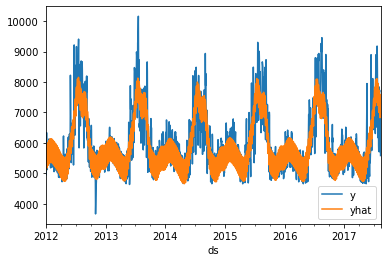

In [22]:
# compare predictions 

pd.concat([nyc_daily_demand.set_index('ds')['y'], preds.set_index('ds')['yhat']], axis = 1).plot()

<AxesSubplot:xlabel='ds'>

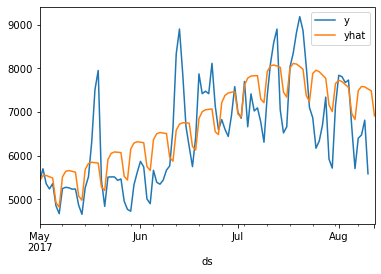

In [23]:
# test set 
pd.concat([test.set_index('ds')['y'], preds.set_index('ds')['yhat']], axis = 1)[-104:].plot()

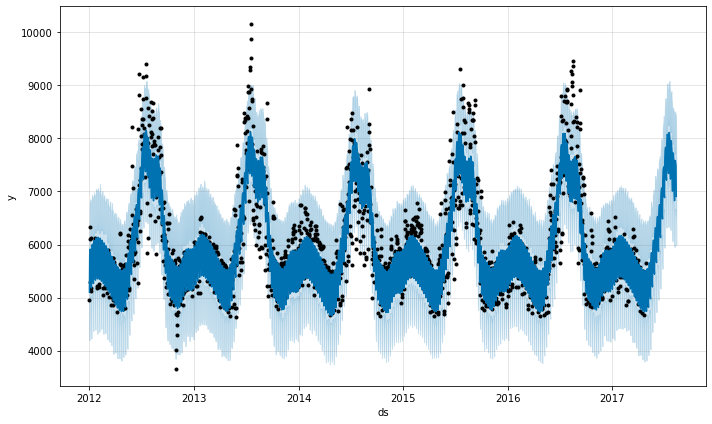

In [24]:
# plot with confidence intervals
fig_1 = model.plot(forecast)

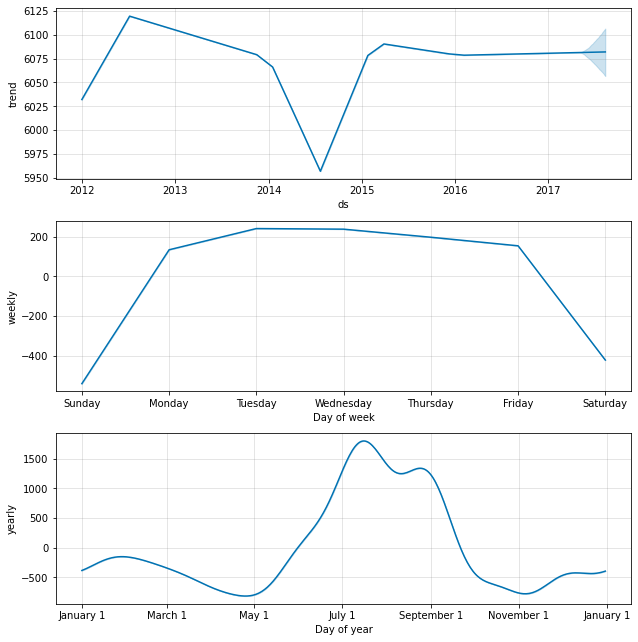

In [25]:
# changepoints are the points where the piecewise linear trend changes

fig_2 = model.plot_components(forecast)

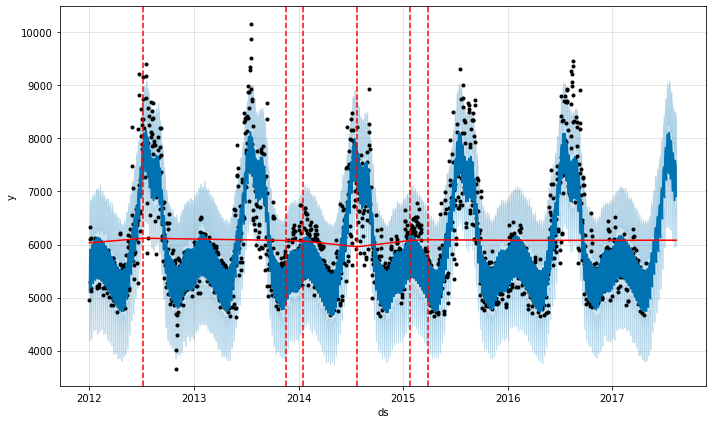

In [26]:
# can manually plot these changepoints, deafault for 80% of the train data.

from fbprophet.plot import add_changepoints_to_plot


fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast, threshold=0.01)

In [27]:
# deltas are the 'delta' values of the change points ?
deltas = model.params['delta'].mean(axis = 0)
deltas

array([-9.58952813e-08, -1.35320368e-07, -1.05071936e-01,  3.62584133e-08,
       -6.04278937e-08, -6.08639043e-08,  4.17841758e-08,  1.77173008e-07,
       -5.09464199e-08, -2.00482771e-07, -2.43483706e-02, -7.14286592e-02,
       -9.49211381e-04,  3.04265417e-08,  2.37281685e-01,  2.11806427e-06,
       -1.41121863e-09, -8.83550999e-02, -4.45469715e-02, -1.17280467e-07,
       -1.73055206e-07, -1.55420067e-08,  3.15975584e-03,  5.90674419e-03,
        1.31278715e-06])

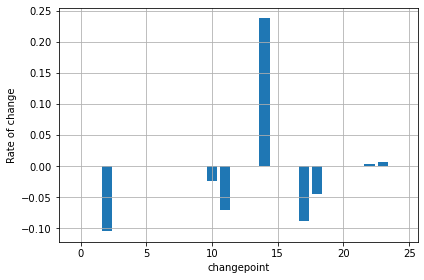

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(deltas)), deltas)
ax.grid(True)
ax.set_ylabel('Rate of change')
ax.set_xlabel('changepoint')
fig.tight_layout()

In [29]:
model.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


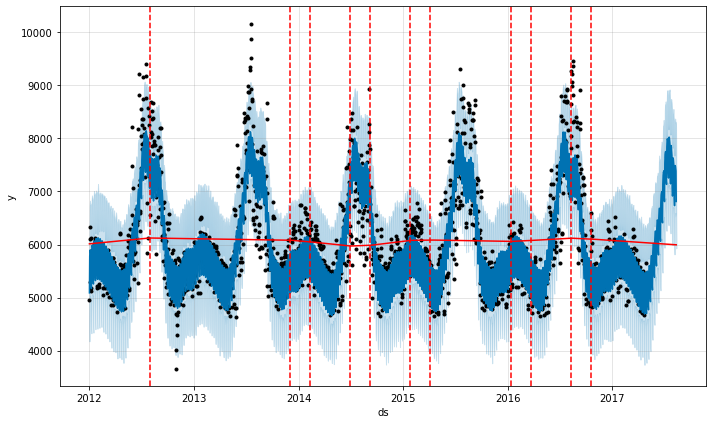

In [30]:
# retraining model for changepoint in 90% of train data

model_change = Prophet(interval_width=0.95, yearly_seasonality=True, changepoint_range=0.9)
model_change.fit(train)
forecast = model_change.predict(df = future)
fig_1 = model_change.plot(forecast)
a = add_changepoints_to_plot(fig_1.gca(), model_change, forecast, threshold=0.01)

In [31]:
## Plotly function to view parts of the preds/time series

from fbprophet.plot import plot_plotly
import plotly.offline as plotly

fig = plot_plotly(model_change, forecast)
plotly.iplot(fig)

#### Cross Validation & Evaluation metrics
Using Diagnostics module

In [32]:
train.ds, test.ds

(0      2012-01-01
 1      2012-01-02
 2      2012-01-03
 3      2012-01-04
 4      2012-01-05
           ...    
 1942   2017-04-26
 1943   2017-04-27
 1944   2017-04-28
 1945   2017-04-29
 1946   2017-04-30
 Name: ds, Length: 1947, dtype: datetime64[ns],
 1947   2017-05-01
 1948   2017-05-02
 1949   2017-05-03
 1950   2017-05-04
 1951   2017-05-05
           ...    
 2046   2017-08-08
 2047   2017-08-09
 2048   2017-08-10
 2049   2017-08-11
 2050   2017-08-12
 Name: ds, Length: 104, dtype: datetime64[ns])

In [33]:
from fbprophet.diagnostics import cross_validation

#Parameters
# The forecast horizon is the length of time into the future for which forecasts are to be prepared. 

# model: Prophet class object. Fitted Prophet model.
# horizon:'5 days','3 hours', '10 seconds'.
# period: string with pd.Timedelta compatible style. Simulated forecast will be done at every this period.
# initial: The first training period will include at least this much data.
# cutoffs: specifying cutoffs to be used during cross validtation. If not provided, they are generated as describedabove.
# parallel :the forecast computation.

# will create 5 folds with 180*4 ~ 720 days. (make sense of this)

cv_results = cross_validation(model = model_change, initial = '731 days', horizon = '365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
cv_results.head()

ds         yhat   yhat_lower   yhat_upper            y     cutoff
0 2014-05-02  5550.149426  4698.454843  6398.827126  5460.325000 2014-05-01
1 2014-05-03  4959.791931  4166.826179  5835.327349  4893.683333 2014-05-01
2 2014-05-04  4835.568277  3983.659154  5745.492783  4764.137500 2014-05-01
3 2014-05-05  5516.106130  4739.497429  6374.032132  5406.762500 2014-05-01
4 2014-05-06  5610.666860  4735.112249  6373.355953  5409.750000 2014-05-01

In [35]:
## Metrics on this CV results

from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(cv_results)
df_p

horizon            mse        rmse         mae      mape  \
0    36 days 12:00:00  232734.897870  482.426054  380.412995  0.068213   
1    37 days 00:00:00  239846.401644  489.741158  388.284374  0.069576   
2    37 days 12:00:00  241234.802363  491.156597  390.772329  0.069989   
3    38 days 00:00:00  244889.357708  494.862969  394.617026  0.070386   
4    38 days 12:00:00  247459.098958  497.452610  398.939565  0.071076   
..                ...            ...         ...         ...       ...   
653 363 days 00:00:00  184897.386933  429.996962  379.069370  0.070358   
654 363 days 12:00:00  182279.781254  426.942363  376.523052  0.069913   
655 364 days 00:00:00  188189.510262  433.808149  381.700750  0.071025   
656 364 days 12:00:00  185419.252135  430.603358  377.761698  0.070334   
657 365 days 00:00:00  184526.773637  429.565797  378.029346  0.070734   

        mdape  coverage  
0    0.055924  0.901099  
1    0.057221  0.895604  
2    0.058016  0.895604  
3    0.058541  0.895604  
4    0.060772  0.895604  
..        ...       ...  
653  0.070271  0.994505  
654  0.070001  0.994505  
655  0.070456  0.989011  
656  0.070001  0.989011  
657  0.070271  0.989011  

[658 rows x 7 columns]

rmse       AxesSubplot(0.125,0.125;0.227941x0.755)
mae     AxesSubplot(0.398529,0.125;0.227941x0.755)
mape    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

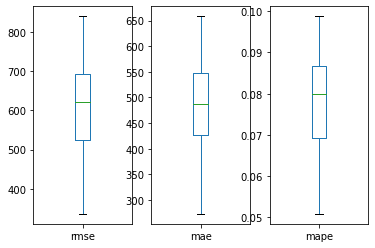

In [46]:
df_p[['rmse','mae', 'mape']].plot(kind='box', subplots=True)